<a href="https://colab.research.google.com/github/yunhoyu/Meat-freshness-classification/blob/main/%EA%B3%A0%EA%B8%B0%EC%8B%A0%EC%84%A0%EB%8F%84%EB%B6%84%EB%A5%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

데이터셋 다운로드

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("vinayakshanawad/meat-freshness-image-dataset")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/vinayakshanawad/meat-freshness-image-dataset/versions/1


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image

In [4]:
!pip install --upgrade seaborn pandas

전처리

데이터 로드

In [4]:
# 데이터셋 경로 설정
train_csv_path = "/content/Meat Freshness.v1-new-dataset.multiclass/train/_classes.csv"
valid_csv_path = "/content/Meat Freshness.v1-new-dataset.multiclass/valid/_classes.csv"

# CSV 파일 불러오기
train_df = pd.read_csv(train_csv_path)
valid_df = pd.read_csv(valid_csv_path)

# 데이터 확인
print(train_df.head())
print(valid_df.head())

                                            filename   Fresh   Half-Fresh  \
0  SPOILED-207-_JPG.rf.4e9025c18a5ae21defb30242a6...       0            0   
1  SPOILED-261-_JPG.rf.4effa4dd0d8c2fe5579aa5859e...       0            0   
2  FRESH-202-_JPG.rf.4f13e1b8c1559b63d140d2942697...       1            0   
3  FRESH-721-_JPG.rf.4f770a93bd104098aa7ffb172a90...       1            0   
4  FRESH-904-_JPG.rf.4f66185dbff0f068ed39414bfdf1...       1            0   

    Spoiled  
0         1  
1         1  
2         0  
3         0  
4         0  
                                            filename   Fresh   Half-Fresh  \
0  HALF-FRESH-8-_JPG.rf.5bf1ec7ab3a5bca8b3a01bbd3...       0            1   
1  FRESH-91-_JPG.rf.5ce4d7d669bae2d26735e4edf0a17...       1            0   
2  FRESH-408-_JPG.rf.5ead7613098bae61f4a33fab1084...       1            0   
3  FRESH-344-_JPG.rf.5e8ec1875092af8f909b876ee314...       1            0   
4  HALF-FRESH-919-_JPG.rf.5f00a599bb9c9b7694db119...       0        

이미지 경로와 레이블 매칭

In [5]:
# 이미지 파일 경로 생성
train_df['image_path'] = "/content/Meat Freshness.v1-new-dataset.multiclass/train/" + train_df['filename']
valid_df['image_path'] = "/content/Meat Freshness.v1-new-dataset.multiclass/valid/" + valid_df['filename']

# 파일 이름에서 클래스 정보 추출 (예: 'FRESH', 'HALF-FRESH', 'SPOILED')
train_df['label'] = train_df['filename'].apply(lambda x: x.split('-')[0])
valid_df['label'] = valid_df['filename'].apply(lambda x: x.split('-')[0])

# 레이블 확인
print(train_df['label'].value_counts())
print(valid_df['label'].value_counts())

label
FRESH      675
HALF       630
SPOILED    510
Name: count, dtype: int64
label
FRESH      178
HALF       159
SPOILED    114
Name: count, dtype: int64


이미지 전처리 및 로딩

In [20]:
from sklearn.model_selection import train_test_split

# 이미지 불러오기 함수 정의
def load_and_preprocess_image(image_path):
    try:
        # 이미지 불러오기 (RGB 포맷으로 변환)
        img = Image.open(image_path).convert('RGB')


        # 이미지 크기를 줄여서 로드 (224x224로 리사이즈)
        img = img.resize((224, 224))


        # 이미지를 numpy 배열로 변환하고 0과 1 사이로 정규화
        img_array = np.array(img) / 255.0

        return img_array
    except Exception as e:
        # 이미지 로딩 중 오류가 발생하면 오류 메시지를 출력하고 None 반환
        print(f"Error loading image {image_path}: {e}")
        return None

# 전처리된 이미지 리스트 생성
train_images = [load_and_preprocess_image(path) for path in train_df['image_path']]
valid_images = [load_and_preprocess_image(path) for path in valid_df['image_path']]

# None 값 제거 (이미지 불러오기 실패한 경우)
train_images = [img for img in train_images if img is not None]
valid_images = [img for img in valid_images if img is not None]

# 레이블 배열 생성
train_labels = train_df['label'].values[:len(train_images)]
valid_labels = valid_df['label'].values[:len(valid_images)]

# Train 데이터를 80% Train, 20% Test로 분할
train_images, test_images, train_labels, test_labels = train_test_split(
    train_images, train_labels, test_size=0.2, random_state=42)


시각화

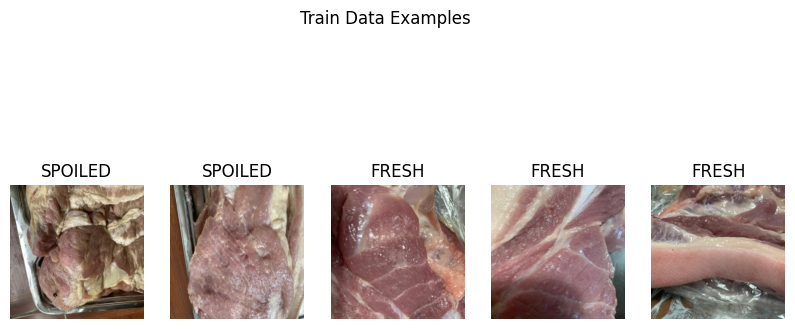

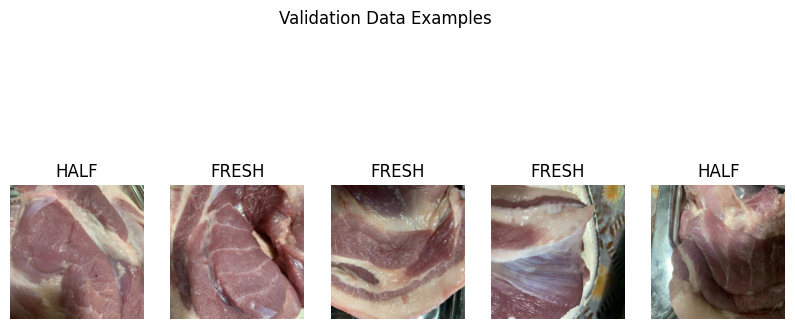

In [7]:
# 시각화

# 시각화 - 훈련 데이터
plt.figure(figsize=(10, 5))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(train_images[i])
    plt.title(train_labels[i])
    plt.axis('off')
plt.suptitle('Train Data Examples')
plt.show()

# 시각화 - 검증 데이터
plt.figure(figsize=(10, 5))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(valid_images[i])
    plt.title(valid_labels[i])
    plt.axis('off')
plt.suptitle('Validation Data Examples')
plt.show()

In [8]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

원-핫 인코딩 변환

In [22]:

# 레이블을 원-핫 인코딩으로 변환
# 레이블이 'FRESH', 'HALF-FRESH', 'SPOILED'로 되어 있으므로, 이를 숫자 레이블로 변환한 후 원-핫 인코딩
label_mapping = {'FRESH': 0, 'HALF': 1, 'SPOILED': 2}
train_labels_numeric = np.array([label_mapping[label] for label in train_labels])
test_labels_numeric = np.array([label_mapping[label] for label in test_labels])
valid_labels_numeric = np.array([label_mapping[label] for label in valid_labels])

train_labels_one_hot = to_categorical(train_labels_numeric, num_classes=3)
test_labels_one_hot = to_categorical(test_labels_numeric, num_classes=3)
valid_labels_one_hot = to_categorical(valid_labels_numeric, num_classes=3)

# 이미지 리스트를 텐서 형태로 변환
train_images_tensor = np.array(train_images)
test_images_tensor = np.array(test_images)
valid_images_tensor = np.array(valid_images)

# 원-핫 인코딩된 레이블 크기 확인
print("Train labels shape:", train_labels_one_hot.shape)
print("Test labels shape:", test_labels_one_hot.shape)
print("Validation labels shape:", valid_labels_one_hot.shape)


Train labels shape: (1452, 3)
Test labels shape: (363, 3)
Validation labels shape: (451, 3)


CNN

In [37]:
import tensorflow as tf
from tensorflow.keras import layers, models


# CNN 모델 생성
model = models.Sequential([
    # 첫 번째 컨볼루션 + 풀링 레이어
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # 두 번째 컨볼루션 + 풀링 레이어
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # 세 번째 컨볼루션 + 풀링 레이어
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # 특성 벡터로 변환 (Flatten)
    layers.Flatten(),
    layers.Dropout(0.5),

    # 완전 연결 레이어
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),

    # 출력 레이어 (다중 클래스 분류)
    layers.Dense(3, activation='softmax')
])

# 모델 요약 출력
model.summary()

# 모델 컴파일
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])



/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,169,347 (42.61 MB)

 Trainable params: 11,169,347 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

모델 학습

In [38]:
from tensorflow.keras.callbacks import EarlyStopping

# EarlyStopping 콜백 정의 (val_loss가 5 에포크 동안 개선되지 않으면 학습을 중지하고 그 중 가장 성능이 좋은 모델의 가중치를 복원)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 모델 학습
history = model.fit(train_images_tensor, train_labels_one_hot,
                    epochs=10,
                    batch_size=32,
                    validation_data=(valid_images_tensor, valid_labels_one_hot),
                    callbacks=[early_stopping])

Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 182s 4s/step - accuracy: 0.3494 - loss: 1.8249 - val_accuracy: 0.3525 - val_loss: 1.0948
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 209s 4s/step - accuracy: 0.3481 - loss: 1.0966 - val_accuracy: 0.3947 - val_loss: 1.0919
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 194s 4s/step - accuracy: 0.3923 - loss: 1.0870 - val_accuracy: 0.4856 - val_loss: 1.0218
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 213s 4s/step - accuracy: 0.5441 - loss: 0.9826 - val_accuracy: 0.4590 - val_loss: 1.0583
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 192s 4s/step - accuracy: 0.6104 - loss: 0.8555 - val_accuracy: 0.6851 - val_loss: 0.7940
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 201s 4s/step - accuracy: 0.7161 - loss: 0.6930 - val_accuracy: 0.6940 - val_loss: 0.7278
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 177s 4s/step - accuracy: 0.7546 - loss: 0.6101 - val_accuracy: 0.7472 - val_loss: 0.6092
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 211s 4s/step - accuracy: 0.7899 - loss: 0.4681 - val_accuracy: 0.7073 - v

모델 평가

In [39]:
# 모델 평가
test_loss, test_accuracy = model.evaluate(test_images_tensor, test_labels_one_hot)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 886ms/step - accuracy: 0.8282 - loss: 0.3894
Test Loss: 0.4264
Test Accuracy: 0.8072


모델 저장

In [41]:
# 모델 저장 (파일 이름은 원하는 대로 변경 가능)
model.save('meat_freshness_cnn_model2.h5')
print("모델이 저장되었습니다!")

모델이 저장되었습니다!


학습 결과

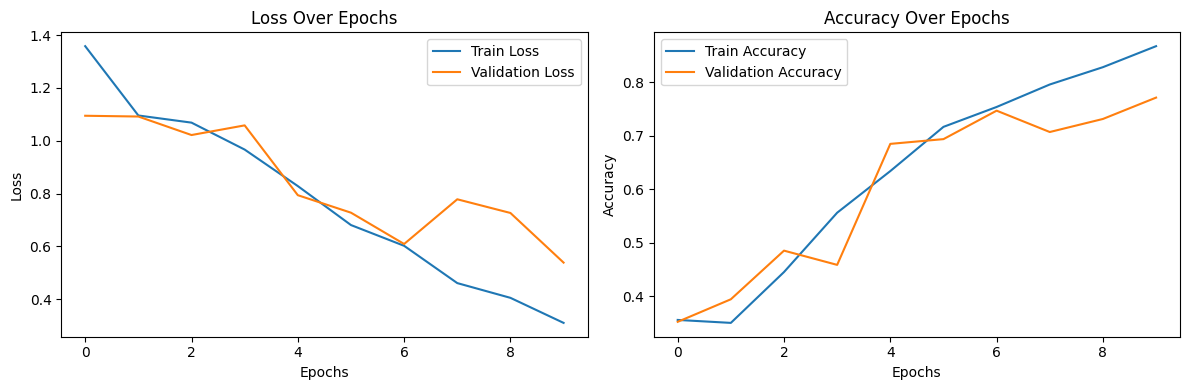

In [42]:
# 학습 손실과 검증 손실 시각화
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# 학습 정확도와 검증 정확도 시각화
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

혼동행렬

15/15 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step


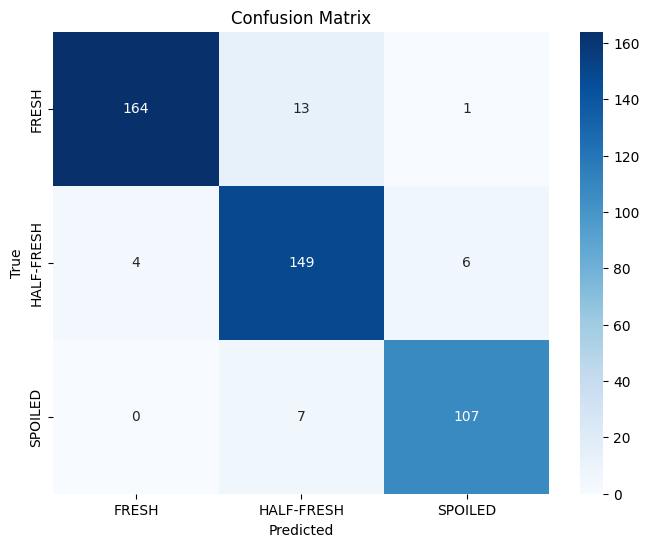

In [25]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# 예측 결과
predictions = model.predict(valid_images_tensor)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(valid_labels_one_hot, axis=1)

# 혼동 행렬 생성
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# 혼동 행렬 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['FRESH', 'HALF-FRESH', 'SPOILED'], yticklabels=['FRESH', 'HALF-FRESH', 'SPOILED'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

예측 결과 시각화

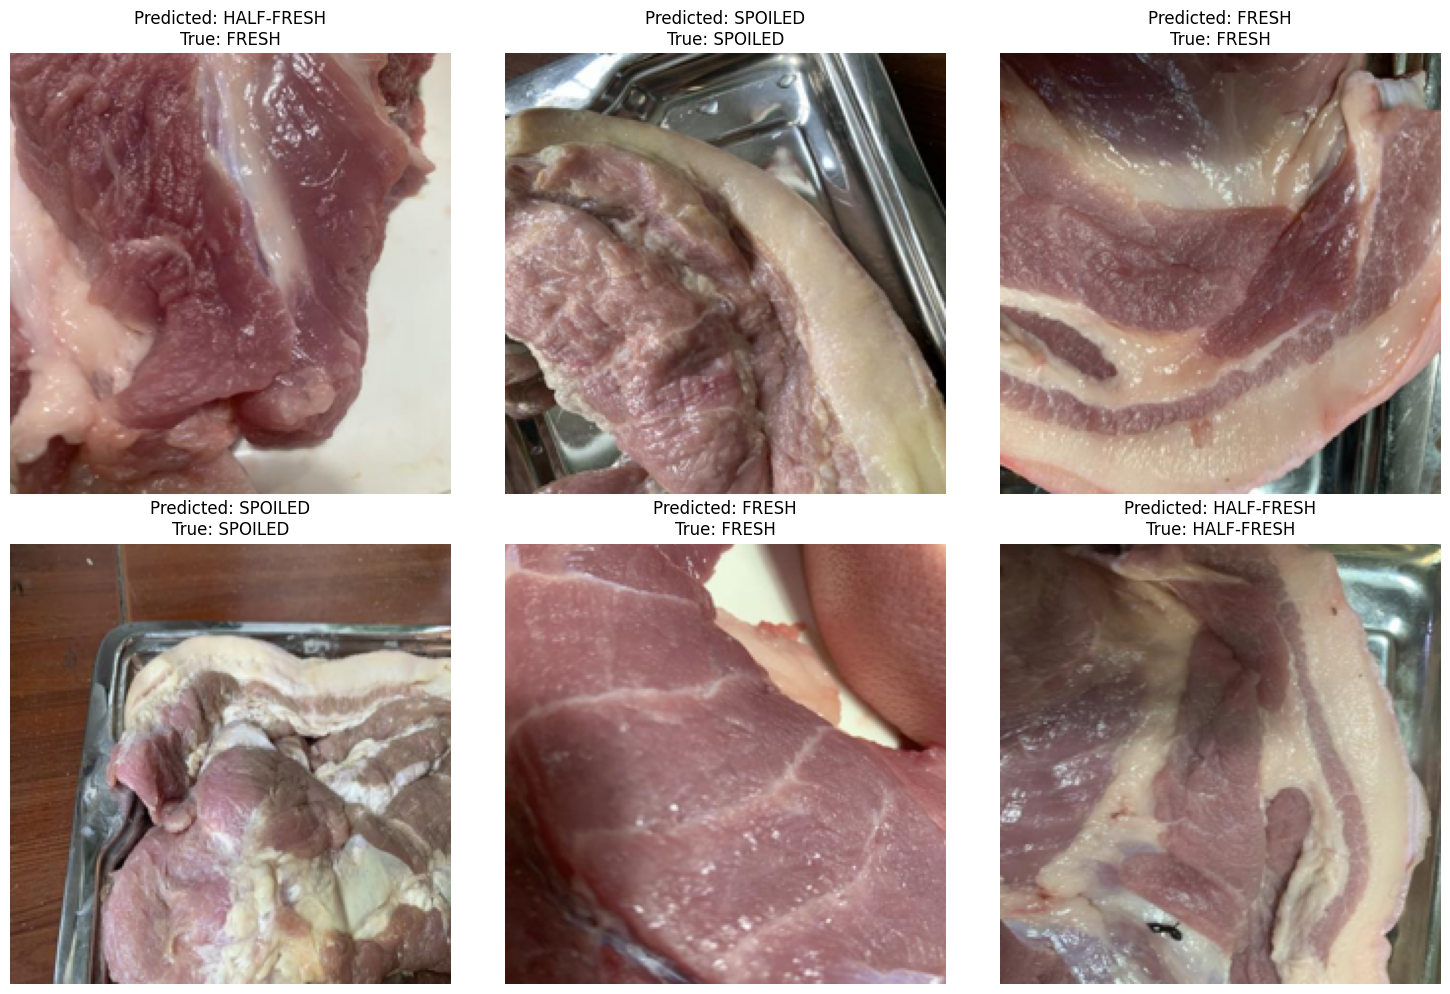

In [32]:
# 랜덤으로 가져올 이미지 개수
num_images = 6

# 랜덤으로 인덱스를 선택
random_indices = np.random.choice(len(valid_images_tensor), num_images, replace=False)

# 예측 결과 시각화
plt.figure(figsize=(15, 10))
for i, idx in enumerate(random_indices):
    plt.subplot(2, 3, i + 1)
    plt.imshow(valid_images_tensor[idx])
    plt.title(f"Predicted: {['FRESH', 'HALF-FRESH', 'SPOILED'][predicted_classes[idx]]}\nTrue: {['FRESH', 'HALF-FRESH', 'SPOILED'][true_classes[idx]]}")
    plt.axis('off')
plt.tight_layout()
plt.show()